In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd
import cv2 as cv2
from PIL import Image
import os
import re
import json
from tqdm import tqdm
import pyocr
!rm -rf ~/.cache/matplotlib
import networkx as nx
import japanize_matplotlib 
from collections import defaultdict

In [2]:
path =  "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/SI-Org-Chart/data/Org_chart/cropped/"
path_json =  "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/SI-Org-Chart/data/Org_chart/output/"
path_clean = "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/SI-Org-Chart/data/Org_chart/clean/"
files_json = os.listdir(path_json)
files_json = [f for f in files_json if os.path.isfile(os.path.join(path_json, f))]
files_json.sort()

In [3]:
def classify_layer(dept_name, rules):
    for layer, keywords in rules.items():
        for keyword in keywords:
            if keyword in dept_name:
                return layer
    return 'Others'


layer_rules = {
    'CEO/Top'   : ['社長','代表','代表取締役', '取締' , '常務', '経営', '株主', '総会'],
    'Management': ['管理', 'マネジメント', '統括' , '監査', '戦略', '支社', '事業部', '本部'],
    'Sales'     : ['営業', 'マーケティング', '販売', 'セールス', '顧客対応', '新規開拓', '商談', '取引', 'プロモーション'],
    'Production': ['生産', '製造', '技術', '開発', '工場', 'システム', 'デザイン', '制作', '製作',
                   '品質管理', '工程', 'ライン', '研究', '設計', 'オペレーション', '生産管理','加工', 'エンジニアリング'],
    'Service'   : ['サービス', 'ソリューション','カスタマーサポート', '顧客サービス', 'アフター', 'サポート', 'コンサル',
                   '修理', '導入支援', '対応', 'メンテナンス', 'トラブル', '対応'],
}

# Test

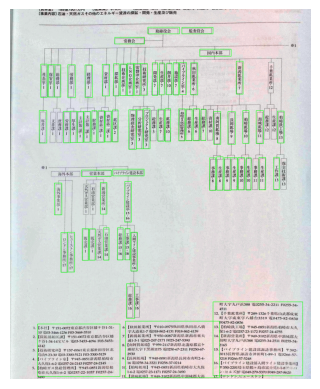

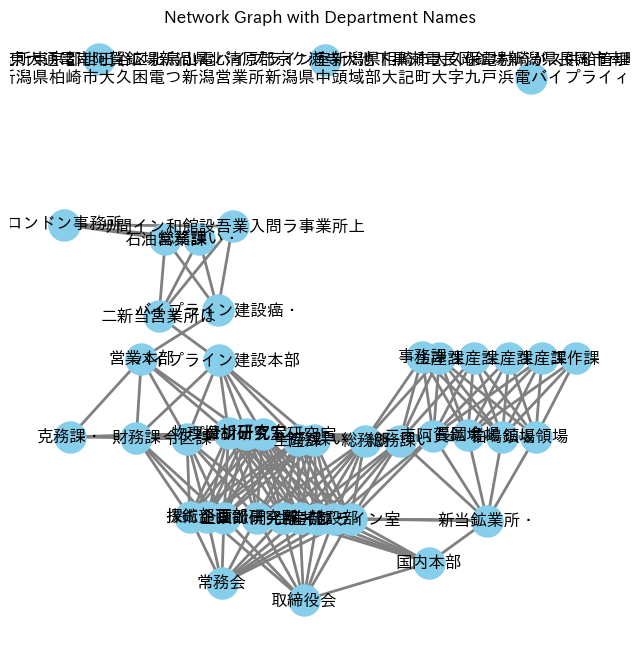

CEO/Top: 2
Others: 22
Production: 13
Management: 4
Sales: 3


In [6]:
i = 12
file_json = os.path.join(path_json, files_json[i])
with open(file_json, "r") as f:
    data = json.load(f)
file = path + data["file_name"][-13:]
# file = path + "2002_7284.png"
image_cv = cv2.imread(file)
image_width, image_height = image_cv.shape[:2] 

centers = []  
dept_names = {}  
tools = pyocr.get_available_tools()
tool = tools[0]

for idx, box in enumerate(data["pred_boxes"]):
    x_min, y_min, x_max, y_max = map(int, box)

    # Draw a rectangle to indicate the detected region
    cv2.rectangle(image_cv, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    cropped = image_cv[y_min:y_max, x_min:x_max]
    gray_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
    pil_image = Image.fromarray(gray_image)
    height, width = gray_image.shape[:2]
    if height < width:
        txt = tool.image_to_string(
            pil_image,
            lang="jpn",
            builder=pyocr.builders.TextBuilder(tesseract_layout=6)
        )
    else:
        txt = tool.image_to_string(
            pil_image,
            lang="jpn_vert",
            builder=pyocr.builders.TextBuilder(tesseract_layout=5)
        )
    result = re.sub(r"[^\u4E00-\u9FFF\u3040-\u309F\u30A0-\u30FF]", "", txt)
    if not result:
        continue
    x_center = int((box[0] + box[2]) / 2)
    y_center = int((box[1] + box[3]) / 2)
    x_normalized = (x_center / image_width) * 10
    y_normalized = (y_center / image_height) * 10
    centers.append({"id": idx, "center": (x_normalized, y_normalized)})
    dept_names[idx] = result

G = nx.Graph()

for center in centers:
    node_id = center["id"]
    G.add_node(node_id, pos=center["center"], label=dept_names.get(node_id, ""))

distance_threshold_lower = 1
distance_threshold_upper = 2
for i in range(len(centers)):
    for j in range(i + 1, len(centers)):
        dist = np.linalg.norm(np.array(centers[i]["center"]) - np.array(centers[j]["center"]))
        if distance_threshold_lower < dist < distance_threshold_upper:
            G.add_edge(centers[i]["id"], centers[j]["id"], weight=dist)

pos = nx.get_node_attributes(G, "pos")
plt.imshow(image_cv)
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

node_labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12,font_family="IPAexGothic")

plt.title("Network Graph with Department Names")
plt.axis('off')
plt.show()

layer_rules = {
    'CEO/Top'   : ['社長','代表','代表取締役', '取締' , '常務', '経営', '株主', '総会'],
    'Management': ['管理', 'マネジメント', '統括' , '監査', '戦略', '支社', '事業部', '本部'],
    'Sales'     : ['営業', 'マーケティング', '販売', 'セールス', '顧客対応', '新規開拓', '商談', '取引先', 'プロモーション'],
    'Production': ['生産', '製造', '技術', '開発', '工場', 'システム', 'デザイン', '制作', '製作',
                   '品質管理', '工程', 'ライン', '研究', '設計', 'オペレーション', '生産管理','加工', 'エンジニアリング'],
    'Service'   : ['サービス', 'ソリューション','カスタマーサポート', '顧客サービス', 'アフター', 'サポート', 'コンサル',
                   '修理', '導入支援', '対応', 'メンテナンス'],
}

def classify_layer(dept_name, rules):
    for layer, keywords in rules.items():
        for keyword in keywords:
            if keyword in dept_name:
                return layer
    return 'Others'

layer_counts = defaultdict(int)
for dept in dept_names.values():
    layer = classify_layer(dept, layer_rules)
    layer_counts[layer] += 1

# print results
for layer, count in layer_counts.items():
    print(f"{layer}: {count}")

In [7]:
results = []
tools = pyocr.get_available_tools()
tool = tools[0]

for i in tqdm(range(100), desc="Processing files"):
    file_json = os.path.join(path_json, files_json[i])
    with open(file_json, "r") as f:
        data = json.load(f)
    file = path + data["file_name"][-13:]
    # file = path + "2002_7284.png"
    image_cv = cv2.imread(file)
    image_width, image_height = image_cv.shape[:2] 

    centers = []  
    dept_names = {}  
    for idx, box in enumerate(data["pred_boxes"]):
        x_min, y_min, x_max, y_max = map(int, box)

        # Draw a rectangle to indicate the detected region
        cv2.rectangle(image_cv, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        cropped = image_cv[y_min:y_max, x_min:x_max]
        gray_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
        pil_image = Image.fromarray(gray_image)
        height, width = gray_image.shape[:2]
        if height < width:
            txt = tool.image_to_string(
                pil_image,
                lang="jpn",
                builder=pyocr.builders.TextBuilder(tesseract_layout=6)
            )
        else:
            txt = tool.image_to_string(
                pil_image,
                lang="jpn_vert",
                builder=pyocr.builders.TextBuilder(tesseract_layout=5)
            )
        result = re.sub(r"[^\u4E00-\u9FFF\u3040-\u309F\u30A0-\u30FF]", "", txt)
        if not result:
            continue
        x_center = int((box[0] + box[2]) / 2)
        y_center = int((box[1] + box[3]) / 2)
        x_normalized = (x_center / image_width) * 10
        y_normalized = (y_center / image_height) * 10
        centers.append({"id": idx, "center": (x_normalized, y_normalized)})
        dept_names[idx] = result

    layer_counts = defaultdict(int)
    for dept in dept_names.values():
        layer = classify_layer(dept, layer_rules)
        layer_counts[layer] += 1

    match = re.search(r"(\d{4})_(\d{4})", file)
    if match:
        year = match.group(1)  # Extracts the year (e.g., "2002")
        code = match.group(2)  # Extracts the code (e.g., "7003")
    else:
        year = None
        code = None

    record = {"year": year, "code": code}
    for key in list(layer_rules.keys()) + ['Others']:
        record[key] = layer_counts.get(key, 0)
    results.append(record)

df_results = pd.DataFrame(results)

Processing files: 100%|██████████| 100/100 [06:42<00:00,  4.02s/it]


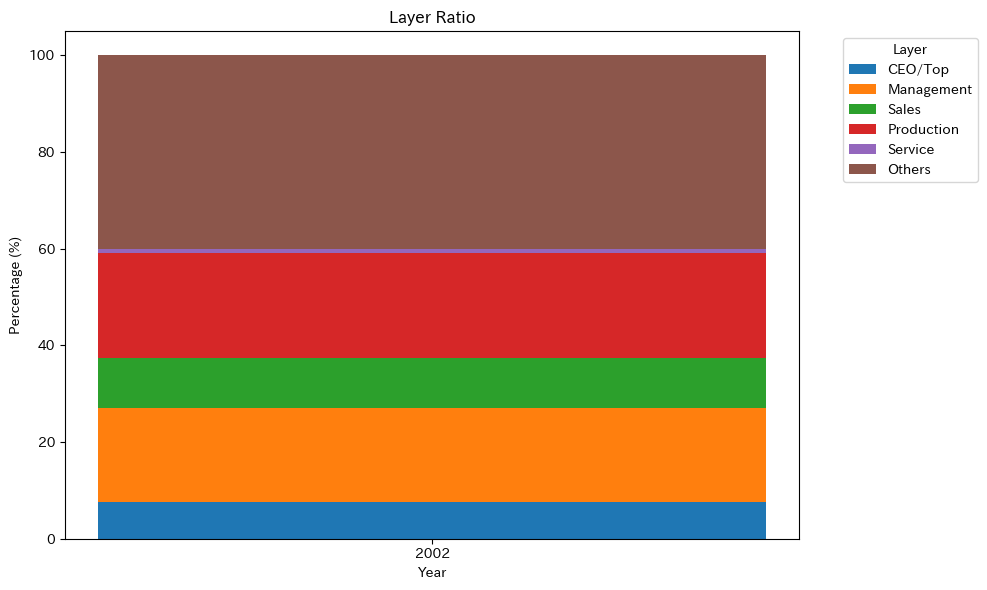

In [10]:
grouped = df_results.groupby('year').sum().reset_index()
layers = ['CEO/Top', 'Management', 'Sales', 'Production', 'Service', 'Others']
grouped['total'] = grouped[layers].sum(axis=1)
for layer in layers:
    grouped[layer + '_pct'] = grouped[layer] / grouped['total'] * 100

grouped_pct = grouped[['year'] + [col + '_pct' for col in layers]].copy()
years = grouped_pct['year'].tolist()
pct_data = {layer: grouped_pct[layer + '_pct'].tolist() for layer in layers}

plt.figure(figsize=(10, 6))
bottom = [0] * len(years)
for layer in layers:
    plt.bar(years, pct_data[layer], bottom=bottom, label=layer)
    bottom = [i+j for i, j in zip(bottom, pct_data[layer])]

plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.title("Layer Ratio")
plt.legend(title="Layer", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()